# Deep learning for change detection on satellite images

In [17]:
# This cell contains the parameters. It should have the tag "parameters"
#Parameters
SRCDIR = "."

In [2]:
# Input path for the image 
name1 = "input_0.png"
name2 = "input_1.png"

In [18]:
# standard imports
import os
import sys
sys.path.append(SRCDIR)  # Will enable local code imports

In [3]:
# library imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr


import numpy as np
from skimage import io
import io as ioo
from IPython import display
import imageio
from IPython.display import Image, display

In [5]:
# local code imports
from fresunet import FresUNet

In [6]:
text_trap = ioo.StringIO()
sys.stdout = text_trap
# execute our now mute function

net, net_name = FresUNet(2*3, 2), 'FresUNet3'
net.load_state_dict(torch.load(os.path.join(SRCDIR,'fresunet3_final.pth.tar')))
# now restore 
#stdout function
sys.stdout = sys.__stdout__



In [7]:
def LoadImages(name1,name2):
    I1 = io.imread(name1).astype('float')
    I1 = (I1 - I1.mean()) / I1.std()

    imageio.imsave("output_0.png",simple_equalization_8bit(I1))
    I2 = io.imread(name2).astype('float')
    I2 = (I2 - I2.mean()) / I2.std()

    imageio.imsave("output_1.png",simple_equalization_8bit(I2))
    
    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')
    
    im1 = reshape_for_torch(I1)
    im2 = reshape_for_torch(I2)
    
    return im1,im2

def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)


def simple_equalization_8bit(im, percentiles=5):
    """
    Simple 8-bit requantization by linear stretching.

    Args:
        im (np.array): image to requantize
        percentiles (int): percentage of the darkest and brightest pixels to saturate

    Returns:
        numpy array with the quantized uint8 image
    """
    import numpy as np
    mi, ma = np.percentile(im[np.isfinite(im)], (percentiles, 100 - percentiles))
    im = np.clip(im, mi, ma)
    im = (im - mi) / (ma - mi) * 255   # scale
    return im.astype(np.uint8)


def compute_map(name1,name2):
    I1, I2 = LoadImages(name1,name2)
    I1 = Variable(torch.unsqueeze(I1, 0).float()) #.cuda()
    I2 = Variable(torch.unsqueeze(I2, 0).float()) #.cuda()
    out = net(I1, I2)
    _, predicted = torch.max(out.data, 1)
    return predicted


In [8]:
p = compute_map(name1,name2)
imageio.imsave("cm.png", ((255*p[0,:,:])).numpy())

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


In [9]:
# Below we create a tabset

::: {.panel-tabset}

### Input images

:::: {.columns}
::: {.column width="49%"}

Image at time T1

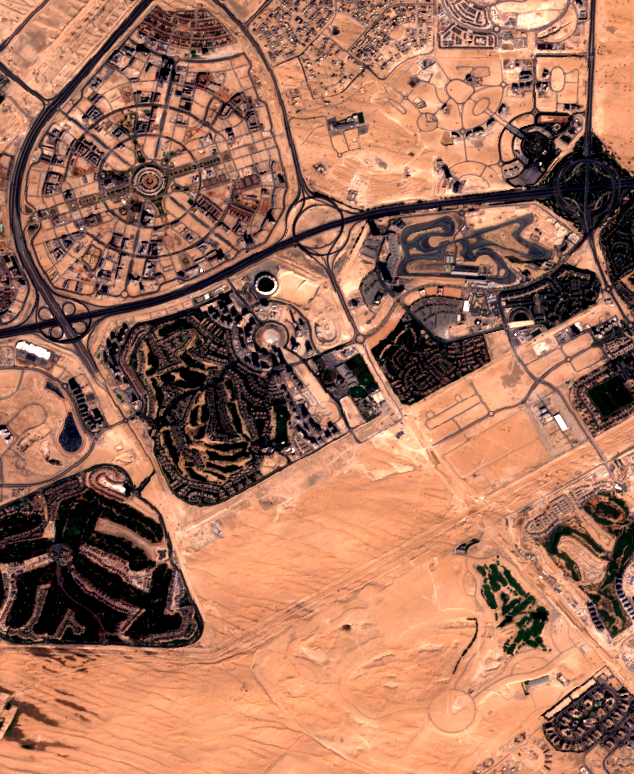

In [10]:
Image("output_0.png")

:::
::: {.column width="49%"}

Image at time T2

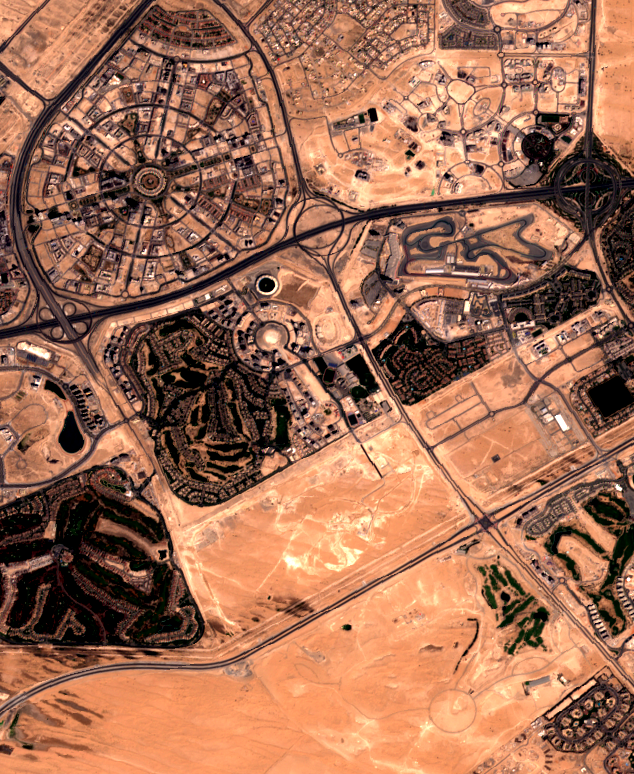

In [11]:
Image("output_1.png")

:::
::::

### Change map

:::: {.columns}
::: {.column width="49%"}

Change map between T1 and T2

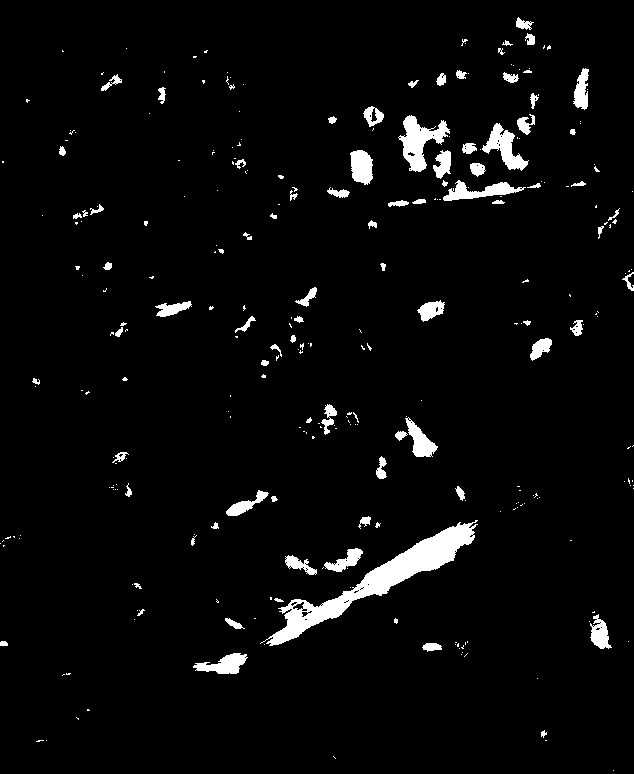

In [12]:
Image("cm.png")

:::
::: {.column width="50%"}

:::
::::

:::